# Using VGG16 Model and Transfer Learning to Determing Fake Face


### Step 1: Import useful libraries 

In [1]:

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import os
import pandas as pd 
import random
from matplotlib import image

Using TensorFlow backend.


### Step 2: Import VGG16 model and freeze its weights 

In [2]:
from keras.applications import VGG16
rows = 224
cols = 224

model = VGG16(weights = 'imagenet', include_top = False, input_shape = (rows, cols, 3))

for layer in model.layers:
    layer.trainable = False

for (i,layer) in enumerate(model.layers):
    print(str(i) + " " + layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


### Step 3: Add two layers after VGG16, one 1-D layer with RELU, and one Classification layer to determine whether the face is real or fake

In [3]:
def addlayer(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(256,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [4]:
# Print out our full model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 2

FC_Head = addlayer(model, num_classes)
modelnew = Model(inputs=model.input, outputs=FC_Head)
print(modelnew.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Step 3: Import train set and limit all images to meet the model requirements

In [5]:
FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [6]:
# Using dataframe to include all images information, real as 1 and fake as 
filenames = os.listdir("C:/Users/vince/MLW/Face_dect/real_and_fake_face/T/")
categories = []
for filename in filenames:
    category = filename.split('_')[0]
    if category == 'real':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df

,filename,category
0,easy_100_1111.jpg,0
1,easy_101_0010.jpg,0
2,easy_102_0101.jpg,0
3,easy_103_1111.jpg,0
4,easy_104_1000.jpg,0
...,...,...
2036,real_01077.jpg,1
2037,real_01078.jpg,1
2038,real_01079.jpg,1
2039,real_01080.jpg,1


In [7]:
df.head()

,filename,category
0,easy_100_1111.jpg,0
1,easy_101_0010.jpg,0
2,easy_102_0101.jpg,0
3,easy_103_1111.jpg,0
4,easy_104_1000.jpg,0


In [8]:
df.tail()

,filename,category
2036,real_01077.jpg,1
2037,real_01078.jpg,1
2038,real_01079.jpg,1
2039,real_01080.jpg,1
2040,real_01081.jpg,1


<AxesSubplot:>

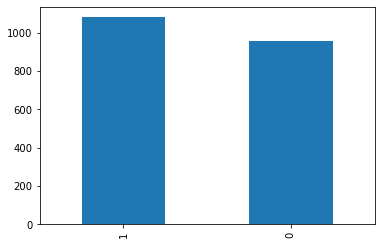

In [9]:
df['category'].value_counts().plot.bar() # Count the total number of images

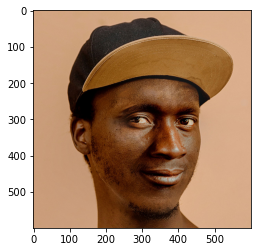

In [17]:
# randomly select one image to print out
sample = random.choice(filenames)
image = load_img("C:/Users/vince/MLW/Face_dect/real_and_fake_face/T/"+sample)
plt.imshow(image)

### Step 4:  Split training set and testing set, building  training generator and testing generator with image augmentation 

In [11]:
df["category"] = df["category"].replace({0: 'fake', 1: 'real'}) 
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=32

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:/Users/vince/MLW/Face_dect/real_and_fake_face/T", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1632 validated image filenames belonging to 2 classes.


In [13]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "C:/Users/vince/MLW/Face_dect/real_and_fake_face/T", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 409 validated image filenames belonging to 2 classes.


### Step 5: Training model with training set 

In [14]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("face_recog_vgg.h5", monitor="val_loss", mode="min", save_best_only = True, verbose=1)
# earlystop = EarlyStopping(monitor= 'val_loss', min_delta = 0, patience = 3, verbose = 1, restore_best_weights = True)
callbacks = [checkpoint]

modelnew.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001),metrics=['accuracy'])

nb_train_samples=1632
nb_validation_samples=409
epochs=20
batch_size=30

history = modelnew.fit_generator(train_generator,
                                 steps_per_epoch=nb_train_samples // batch_size,
                                 epochs=epochs,
                                 callbacks=callbacks,
                                 validation_data=validation_generator,
                                 validation_steps=nb_validation_samples // batch_size)
model.save_weights("model.h5")

Epoch 1/20
54/54 [==============================] - 346s 6s/step - loss: 0.7253 - accuracy: 0.5312 - val_loss: 0.7316 - val_accuracy: 0.4719

Epoch 00001: val_loss improved from inf to 0.73162, saving model to face_recog_vgg.h5
Epoch 2/20
54/54 [==============================] - 371s 7s/step - loss: 0.6788 - accuracy: 0.5770 - val_loss: 0.6487 - val_accuracy: 0.5990

Epoch 00002: val_loss improved from 0.73162 to 0.64871, saving model to face_recog_vgg.h5
Epoch 3/20
54/54 [==============================] - 372s 7s/step - loss: 0.6736 - accuracy: 0.5845 - val_loss: 0.6651 - val_accuracy: 0.6161

Epoch 00003: val_loss did not improve from 0.64871
Epoch 4/20
54/54 [==============================] - 370s 7s/step - loss: 0.6627 - accuracy: 0.6215 - val_loss: 0.6498 - val_accuracy: 0.6357

Epoch 00004: val_loss did not improve from 0.64871
Epoch 5/20
54/54 [==============================] - 378s 7s/step - loss: 0.6669 - accuracy: 0.5955 - val_loss: 0.8095 - val_accuracy: 0.5159

Epoch 00005:

### Step 6: Plot training accuracy and loss

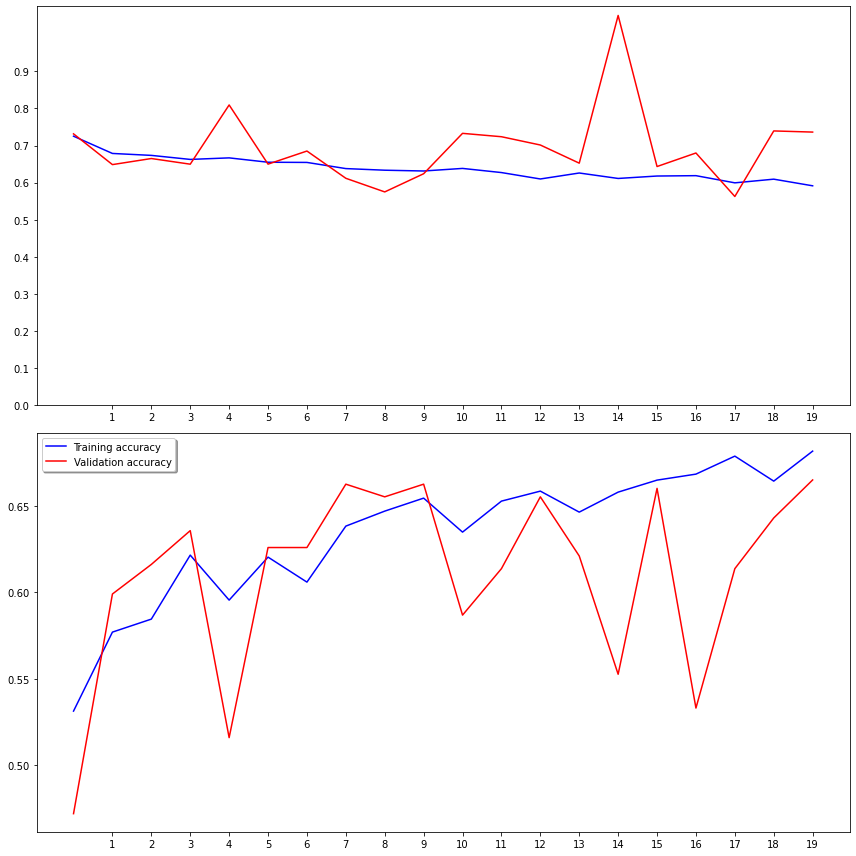

In [15]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()